Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Load CIFAR-10

In [2]:
transform = transforms.Compose([ # Pipeline
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
]) # Normalized_pixel = (pixel - mean) / std, where mean = std = 0.5 for each color channel
# Why 0.5?
# Before toTensor, pixel values are between [0, 255]
# After toTensor, pixel values are between [0, 1]
# 0.5 is the center of that range: normalizing with (mean=0.5, std=0.5) maps values to [-1, 1]
# which will cause the values to have a mean of zero which make NNs learn faster

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader( # Split data into mini-batches
    trainset, batch_size=64, shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False
)


100%|██████████| 170M/170M [05:50<00:00, 486kB/s]  


Visualize some images

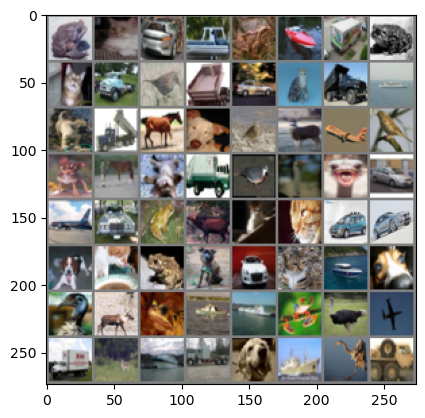

In [7]:
import numpy as np
# Convert tensor to numpy image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if normalized
    npimg = img.numpy()
    # Transpose from (C,H,W) to (H,W,C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


CNN Architecture

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)    
    # conv1 → feature extraction
    # ReLU → non-linearity
    # MaxPool → Reduce size
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
 

Training Loop

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
for epoch in range(10):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1, Loss: 1.2876
Epoch 2, Loss: 0.9064
Epoch 3, Loss: 0.7380
Epoch 4, Loss: 0.5980
Epoch 5, Loss: 0.4671
Epoch 6, Loss: 0.3500
Epoch 7, Loss: 0.2486
Epoch 8, Loss: 0.1695
Epoch 9, Loss: 0.1209
Epoch 10, Loss: 0.0879


Evaluation

In [6]:
correct, total = 0, 0
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 72.41%
